# Introduction

Welcome to my project to collect business contact information! This project aims to collect email addresses and Instagram paths, for various type of businesses. Email lists are useful for marketing, networking, collaboration, customer service, and research. They allow businesses and organizations to communicate with their audience and achieve their goals.

The project is divided into two parts: **Google Maps Webscraping** and **Contact Information Searching**.

# 1. Google Maps Webscraping

> The first part of the project involves scraping store information from Google Maps. We will be using a web scraping tool to extract data such as the store's name, address, star rating, number of reviews, and most importantly, websites. This information will be stored in a Pandas DataFrame for later use. Once we have collected all of the relevant data, we will proceed to the second part of the project.

# 2. Contact Information Searching

> The second part of the project involves visiting each of the websites we have scraped in the first part and searching for email addresses and Instagram paths. Once we have located the email addresses and Instagram paths, we will store them in the DataFrame along with the other information we have collected. This will allow us to have a comprehensive list of contact information.

[A demo video of the scraping process can be found here!](https://github.com/Johneration/Collecting-Email-Addresses-From-Google-Maps/blob/main/web_scraper_demo_video.mp4?raw=true)

This script has a wide range of applications. You can search for any type of business in any location, and specify how many stores to return. This makes it a versatile tool for tasks such as building a database of contact information or gathering data for market research.

# Import Modules

In [1]:
# Import the necessary packages for this project

import requests
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
from bs4 import BeautifulSoup as bs
from datetime import datetime
import pandas as pd
import time
import os
import re

# 1. Google Maps Webscraping

In [2]:
# The html source of google.com/maps cannot be accessed solely through the requests module because it is a dynamic website
# As a result, we will utilize the Selenium module to scrape the information on the website

def open_driver():
    options = webdriver.ChromeOptions()
    options.add_argument('--ignore-certificate-errors')
    options.add_argument('--incognito')
    driver = webdriver.Chrome(ChromeDriverManager().install(), chrome_options=options)
    return driver

In [3]:
# Create the URL to scrpae the information from
# To create a URL, the location and keyword (e.g., type of business, such as bar or cafe) must be passed in.

def get_search_url(location, keyword):
    location = location.replace(', ', '+').replace(' ', '+')
    search_url = f'https://www.google.com/maps/search/{location}+{keyword}'
    return search_url

def drive_to_page(driver, search_url):
    driver.get(search_url)
    time.sleep(0.5)

In [4]:
# Once the targeted URL is reached, scroll down the page to the targeted search results.

def scroll_to(driver, n):
        target_xpath = f'//*[@id="QA0Szd"]/div/div/div[1]/div[2]/div/div[1]/div/div/div[2]/div[1]/div[{n}]'
        element = driver.find_element('xpath', target_xpath)
        driver.execute_script("arguments[0].scrollIntoView(true);", element)
        return element

def scroll_page_down(driver, count):
    current_index = 3
    target_index = (count*2) + 1
    w = 0
    while current_index <= target_index:
        try:
            scroll_to(driver, current_index)
            current_index += 2
        except:
            bottom_index = (current_index-1)/2 - 1
            html = driver.page_source
            soup = bs(html, 'html.parser')
            result_count = len(soup.find_all('div', {'role': 'article'}))
            if bottom_index > result_count:
                break
            else:
                if w >= 10:
                    break
                else:
                    w += 1
                    time.sleep(1)
                    continue
    time.sleep(0.5)
    current_index -= 4
    return current_index

In [11]:
def start_scraping(driver, location, keyword, current_index):
        
    # Define the function to scrape information of the search results, such as name, rating, price, and website
    def get_result_data(location, keyword, result_soup):
        true_icon = 'https://maps.gstatic.com/consumer/images/icons/2x/ic_done_18px.png'
        page_info = {}
        try:
            page_info['name'] = result_soup.find('h1', {'class': 'DUwDvf fontHeadlineLarge'}).get_text().strip(" ")
        except:
            page_info['name'] = ''
        try:
            page_info['rate'] = float(result_soup.find('div', {'role': 'button', 'class': 'F7nice mmu3tf'}).find('span', {'jsan': '0.aria-hidden'}).text)
        except:
            page_info['rate'] = ''
        try:
            page_info['reviews'] = int(result_soup.find('div', {'role': 'button', 'class': 'F7nice mmu3tf'}).find('span', {'jsan': '0.aria-label'}).text.split()[0].replace(',', ''))
        except:
            page_info['reviews'] = ''
        try:
            page_info['category'] = result_soup.find('button', {'jsaction': 'pane.rating.category'}).text
        except:
            page_info['category'] = ''
        try:
            page_info['price'] = result_soup.find('span', {'class': 'mgr77e'}).find('span', {'jsan': '0.aria-label'}).text
        except:
            page_info['price'] = ''
        try:
            page_info['description'] = result_soup.find('div', {'class': 'PYvSYb'}).text.strip(" ")
        except:
            page_info['description'] = ''
        try:
            info_source = result_soup.find('div', {'role': 'region', 'class': 'm6QErb', 'jsan': 't-dgE5uNmzjiE,7.m6QErb,0.aria-label,0.role'})
            row_source_ls = info_source.find_all('div', {'class': 'RcCsl fVHpi w4vB1d NOE9ve M0S7ae AG25L'}) + info_source.find_all('div', {'class': 'RcCsl rJl64b w4vB1d NOE9ve M0S7ae AG25L'})
            row_len = len(row_source_ls)
            info = {}
            for i in range(0, row_len):
                dic = row_source_ls[i].find('button').attrs | row_source_ls[i].find('a').attrs # Merge 2 attrs dics
                if ': ' in dic['aria-label']:
                    key = dic['aria-label'].split(': ')[0]
                    value = dic['aria-label'].split(': ')[1]
                    info[key] = value
            page_info['info'] = info
        except:
            page_info['info'] = ''
        return page_info
    
    # Once the targeted search results have been reached, we need to scroll through the items and scrape their corresponding contents one by one all the way to the first result
    # It is because it is a dynamic site, the page would only load a certain amount of items when they are scrolled to
    dic_ls = []
    t = 1
    total_items = (current_index-1)/2
    while current_index >= 3:
        element = scroll_to(driver, current_index)
        element.click()
        if t == 1:
            time.sleep(5)
        else:
            time.sleep(2.5)
        result_source = driver.page_source
        result_soup = bs(result_source, 'html.parser')
        page_info = get_result_data(location, keyword, result_soup)
        page_info['position'] = int((current_index-1)/2)
        dic_ls.append(page_info)
        process = round((t/total_items)*100, 2)
        print(f'{process}%')
        current_index -= 2
        t += 1
    
    # All of the information is stored in a list of dictionaries
    # Convert it into a Pandas DataFrame for further processing
    df = pd.DataFrame(dic_ls)
    df.sort_values(by='position', inplace=True)
    df = df.set_index('position')
    
    # Extract the 'website' attribute from the 'info' dictionary, as it will later be used to get the email addresses and Instagram paths.
    websites = []
    for i in df['info']:
        try:
            if 'Website' in list(i.keys()):
                i = 'https://' + i['Website'].replace(' ', '')
            else:
                i = ''
            websites.append(i)
        except:
            i = ''
            websites.append(i)
    df['Website'] = websites
    return df

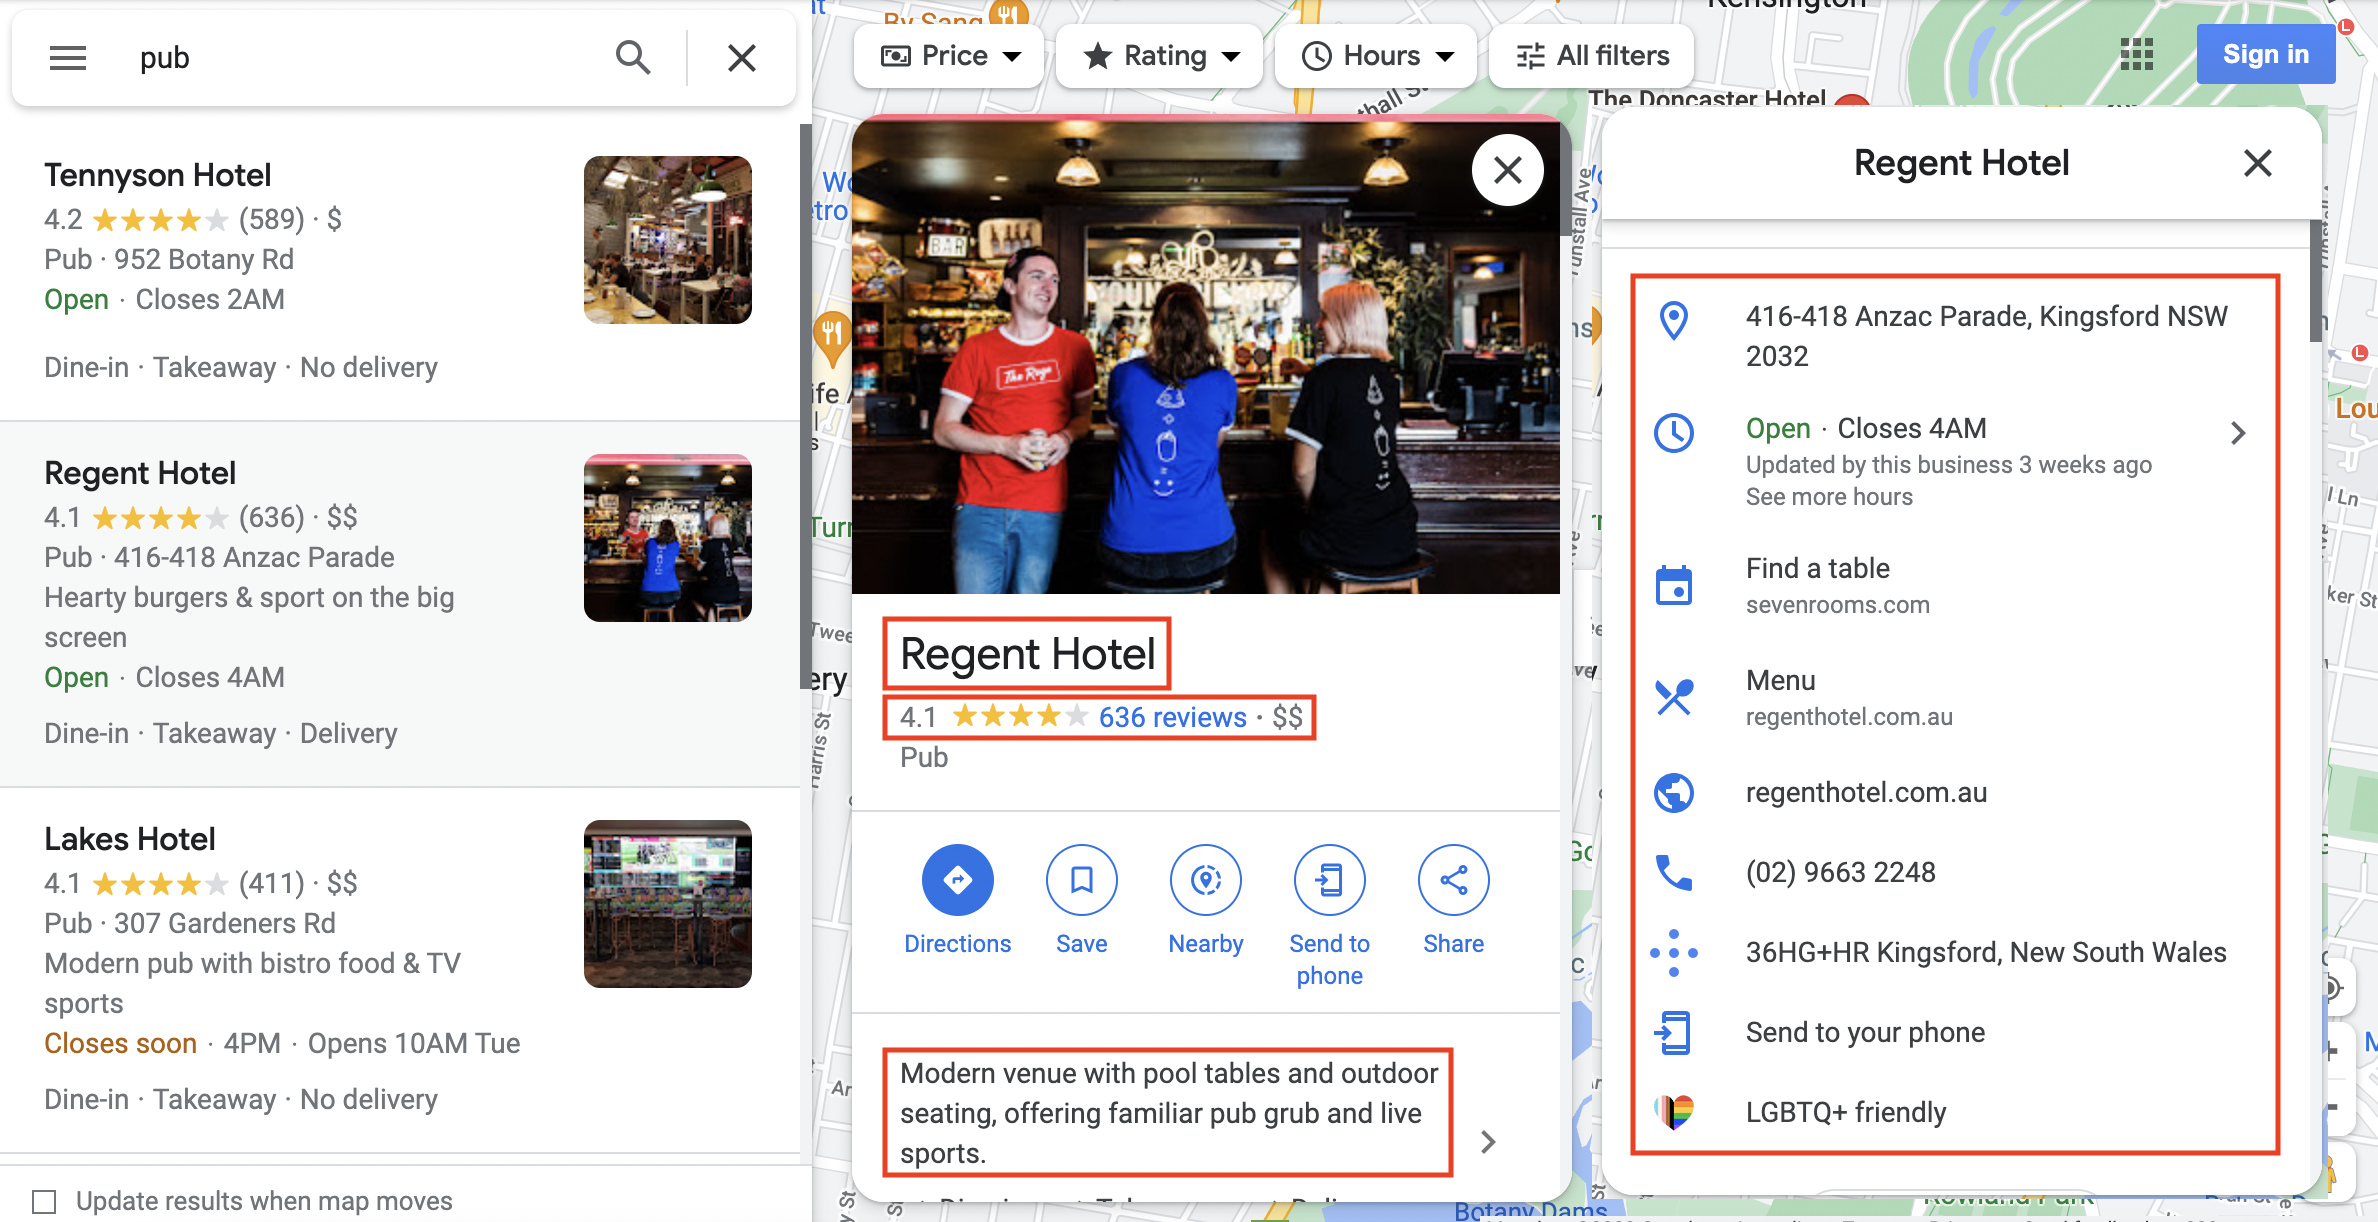

# 2. Contact Information Searching

In [6]:
# Create a function to go through the page sources of all websites
# Email addresses and Instagram paths will be returned if the patterns of email and Instagram paths are found in the page source

def get_email_ig(location, df):
    emails_ls = []
    igs_ls = []
    for ind, i in enumerate(df['Website']):
        email_pattern = r'(\w+@\w+\.com(\.\w+)?)'
        ig_pattern = r'(https?://(www\.)?instagram.com/\w+)'

        if type(i) is not float:
            try:
                html = requests.get(i, timeout=10).text
                emails = re.findall(email_pattern, html)
                emails = [full for full, match in emails]
                emails = list(set(emails))
                igs = re.findall(ig_pattern, html)
                igs = [full for full, match in igs]
                igs = list(set(igs))
                if not emails:
                    html = requests.get(i + '/contact', timeout=10).text
                    emails = re.findall(email_pattern, html)
                    emails = [full for full, match in emails]
                    emails = list(set(emails))
            except:
                emails = []
                igs = []
        else:
            emails = []
            igs = []

        emails_ls.append(emails)
        igs_ls.append(igs)
        process = round(((ind+1)/len(df['Website']))*100, 2)
        print(f'{process}%')

    df['Email'] = emails_ls
    df['IG'] = igs_ls
    return df

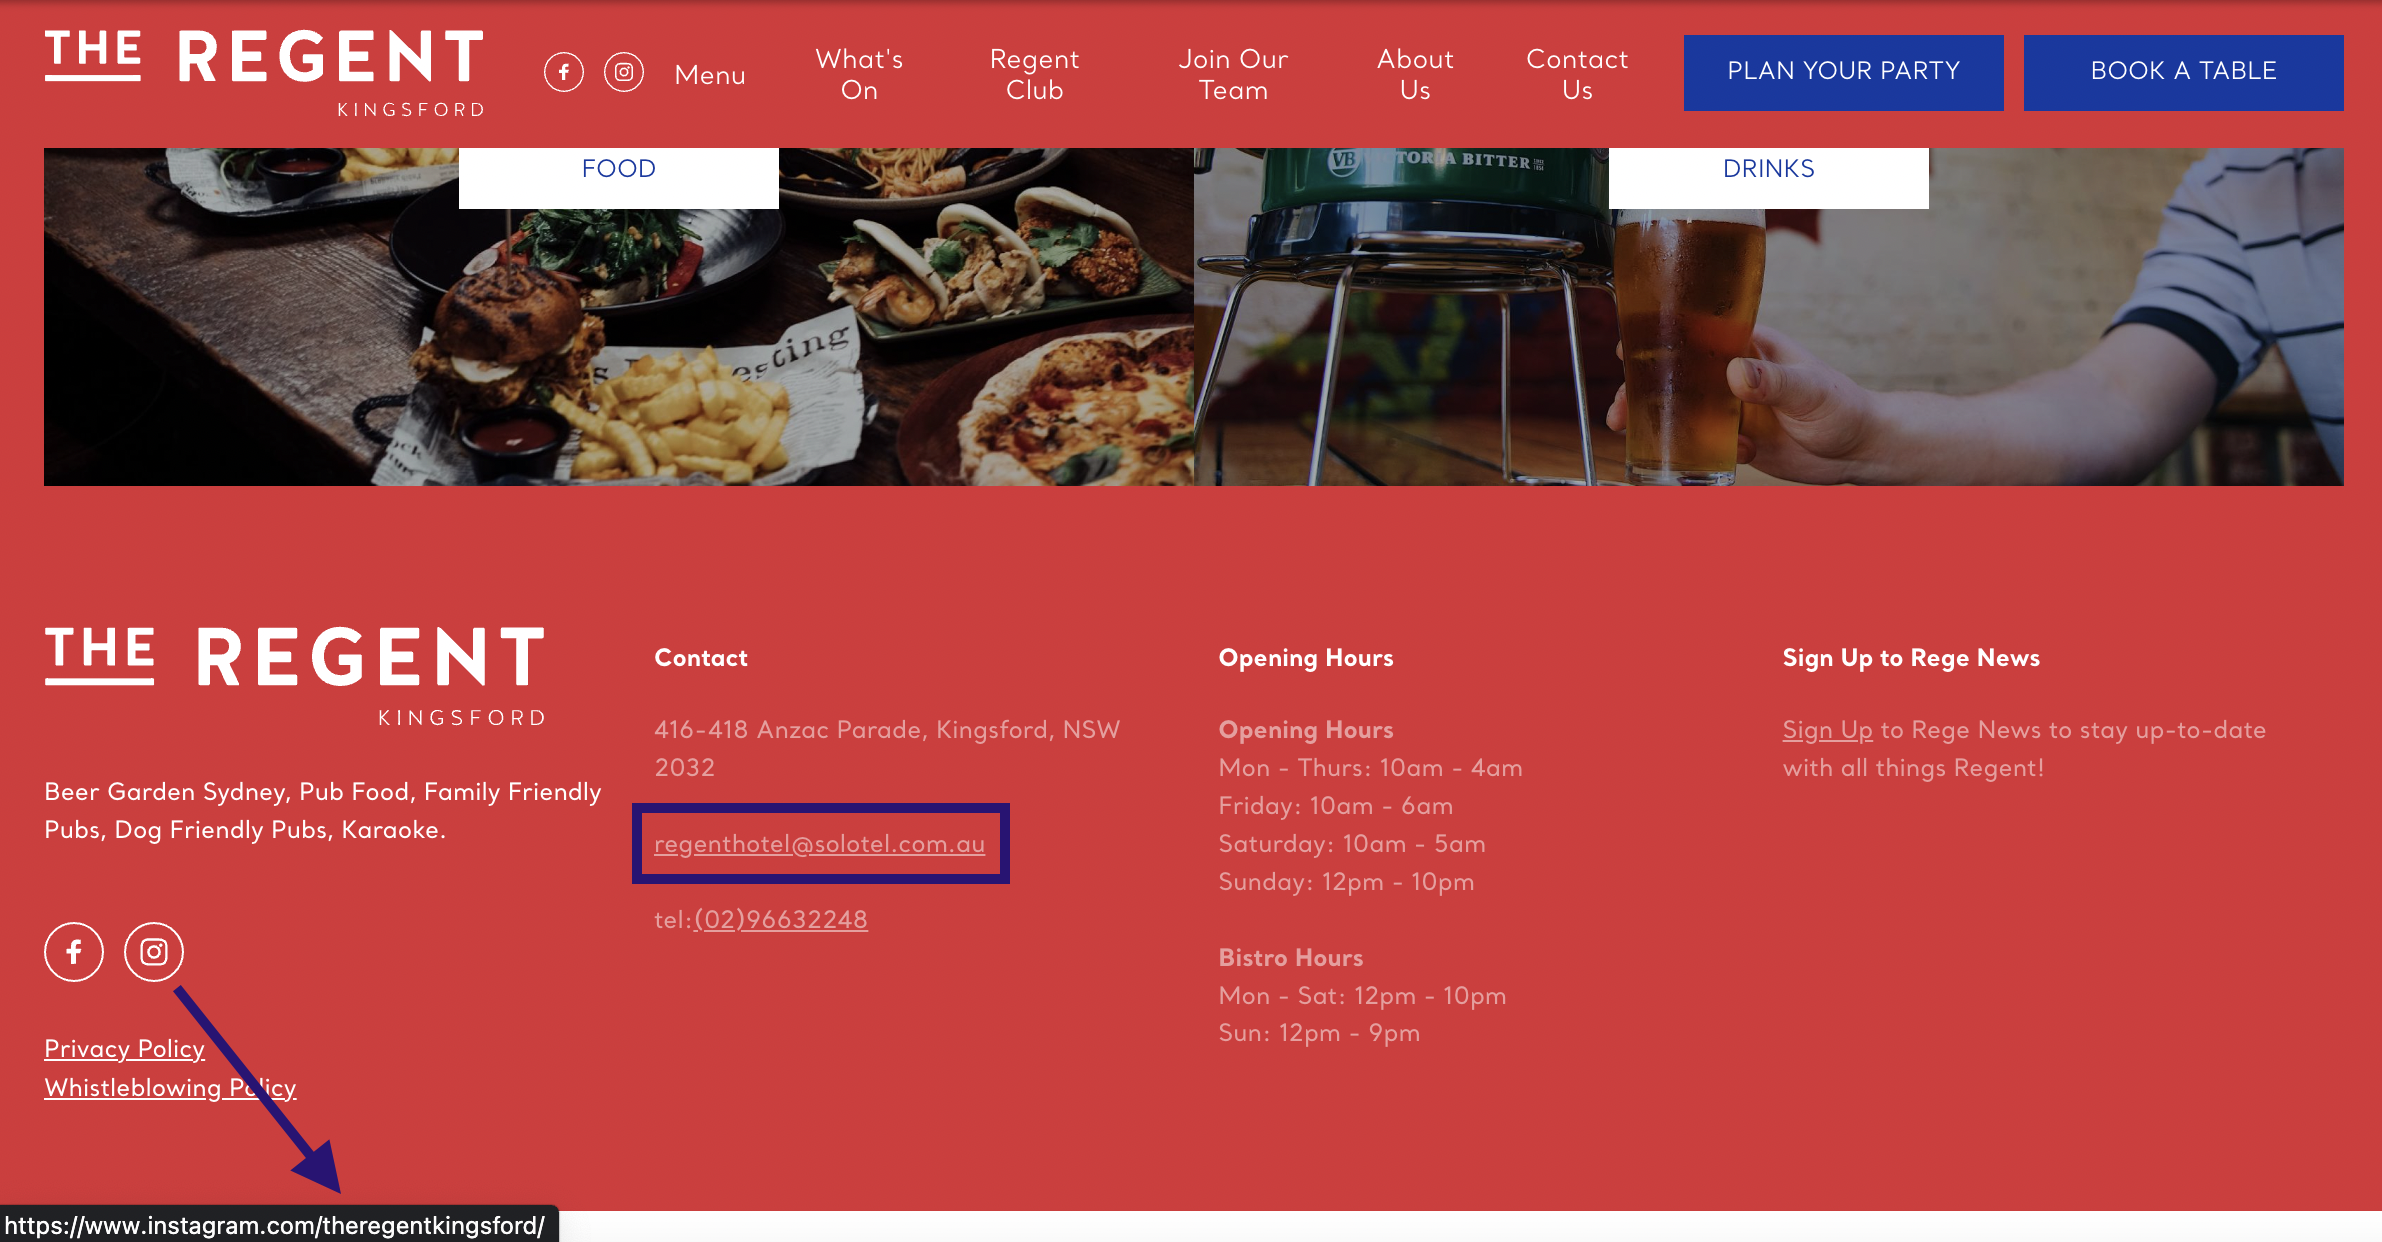

# Run The Script

In [13]:
# Define the main program of the script

def main(driver, location, keyword, count=10):
    count += 1
    print(f'\U0001F680 \033[1m{location} + {keyword}\033[0m \U0001F680')
    print(datetime.now().strftime("%H:%M:%S"))
    print('')
    search_url = get_search_url(location, keyword)
    drive_to_page(driver, search_url)
    print('\U0001F31F Driven to web page:', search_url)
    print('---')
    current_index = scroll_page_down(driver, count)
    print('\U0001F31F Scrolled down to targeted result')
    print('---')
    print('\U0001F31F Start Scraping\n')
    print('Progress:')
    df = start_scraping(driver, location, keyword, current_index)
    print('\n\U0001F31F Finished Scraping')
    print(datetime.now().strftime("%H:%M:%S"))
    print('---')
    print('\U0001F31F Start Processing\n')
    print('Progress:')
    df = get_email_ig(location, df)
    print('\n\U0001F31F Finished Processing')
    print('---')
    return df

In [15]:
# Activate a Google Chrome Driver

driver = open_driver()

In [20]:
# To run the script, the location, keyword (e.g., type of business, such as bar or cafe) and number of the results must be passed in
# In this case, we have chosen 'sydney' as the location and 'bar' as the keyword

main(driver, 'sydney', 'bar', count=10)

🚀 sydney + bar 🚀
16:31:07

🌟 Driven to web page: https://www.google.com/maps/search/sydney+bar
---
🌟 Scrolled down to targeted result
---
🌟 Start Scraping

Progress:
10.0%
20.0%
30.0%
40.0%
50.0%
60.0%
70.0%
80.0%
90.0%
100.0%

🌟 Finished Scraping
16:31:45
---
🌟 Start Processing

Progress:
10.0%
20.0%
30.0%
40.0%
50.0%
60.0%
70.0%
80.0%
90.0%
100.0%

🌟 Finished Processing
---


name  rate  reviews      category price  \
position                                                              
1         Bar 83 at Sydney Tower   4.2      433           Bar         
2                  Grandma's Bar   4.5      859           Bar    $$   
3                Old Mates Place   4.7      789           Bar    $$   
4                Papa Gede's Bar   4.8      921           Bar    $$   
5             Employees Only Bar   4.3      661  Cocktail bar    $$   
6                    Cantina OK!   4.8      438           Bar    $$   
7            Double Deuce Lounge   4.8      196  Cocktail bar    $$   
8                 The Baxter Inn   4.7     2986           Bar   $$$   
9                     Door Knock   4.5      603  Cocktail bar   $$$   
10                          PS40   4.6      464  Cocktail bar    $$   

                                                description  \
position                                                      
1                                                             
2         Eclectic cocktails and jaffles in a laid-back ...   
3         Elevated saloon providing drinks & light fare ...   
4         Intimate hangout with voodoo-themed decor, off...   
5         Fashionable, buzzing cocktail bar offering sop...   
6         Compact, rustic-chic bar specialising in marga...   
7                                                             
8         Sophisticated bar featuring an extensive selec...   
9                                                             
10                                                            

                                                       info  \
position                                                      
1         {'Address': 'Westfield Sydney, Level 4/108 Mar...   
2         {'Address': 'Basement/275 Clarence St, Sydney ...   
3         {'Address': 'level 4/199 Clarence St, Sydney N...   
4         {'Address': '348 Kent St, Sydney NSW 2000 ', '...   
5         {'Address': '9a Barrack St, Sydney NSW 2000 ',...   
6         {'Address': 'Council Pl, Sydney NSW 2000 ', 'W...   
7         {'Address': '6 Bridge St, Sydney NSW 2000 ', '...   
8         {'Address': '152/156 Clarence St, Sydney NSW 2...   
9         {'Address': 'Basement/70 Pitt St, Sydney NSW 2...   
10        {'Address': '40 King St Enter, Skittle Lane, S...   

                                   Website  \
position                                     
1          https://bar83sydneytower.com.au   
2         https://grandmasbarsydney.com.au   
3                  https://oldmates.sydney   
4                    https://papagedes.com   
5             https://employeesonlysyd.com   
6                    https://okokok.com.au   
7            https://doubledeucelounge.com   
8                   https://swillhouse.com   
9                 https://doorknock.com.au   
10                     https://ps40bar.com   

                                                      Email  \
position                                                      
1                                                        []   
2                            [kimmy@liquidandlarder.com.au]   
3                                                        []   
4                                                        []   
5                               [info@employeesonlysyd.com]   
6            [shop@cantinaok.com.au, more@cantinaok.com.au]   
7                           [charlie@doubledeucelounge.com]   
8         [pretzels@thebaxterinn.com, pizza@frankiespizz...   
9                             [knockknock@doorknock.com.au]   
10                                   [bookings@ps40bar.com]   

                                                         IG  
position                                                     
1                                                        []  
2         [http://instagram.com/theroversurryhills, http...  
3                                                        []  
4                                        